In [1]:
from google.colab import drive
from numpy import load
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from PIL import Image
import hashlib

In [ ]:
# Mount drive and load data
drive.mount('/gdrive')
data = load('/gdrive/MyDrive/training_set.npz', allow_pickle=True)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Load data
images = data['images'] / 255
labels = data['labels']
labels = labels.reshape(-1)

In [4]:
print(images.shape)

(13759, 96, 96, 3)


# Delete shrek and rick

In [ ]:
# Index of shrek and rick
shrek_idx = 13302
rick_idx = 13758

In [ ]:
# Remove shrek and rick
to_remove_idx = []
for i, img in enumerate(images):
    if np.array_equal(img, images[shrek_idx]) or np.array_equal(img, images[rick_idx]):
      to_remove_idx.append(i)

images = np.delete(images, to_remove_idx, axis=0)
labels = np.delete(labels, to_remove_idx, axis=0)

In [7]:
print(images.shape)

(11959, 96, 96, 3)


# Delete duplicates

In [ ]:
import numpy as np

# Compute a hash for each image to identify unique images
unique_hashes = {}
unique_indices = []

for idx, img in enumerate(images):
    # Flatten image, compute a unique hash, and use it as an identifier
    img_hash = hashlib.md5(img.tobytes()).hexdigest()  # Hash the bytes of the image

    if img_hash not in unique_hashes:
        # If this hash is not already in the unique set, add it
        unique_hashes[img_hash] = idx
        unique_indices.append(idx)

# Extract unique images and labels using unique indices
unique_images = images[unique_indices]
unique_labels = labels[unique_indices]

# unique_images now contains only unique images
print(unique_images.shape)


(11951, 96, 96, 3)


In [9]:
del images
del labels
del to_remove_idx

# Balancing

In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(unique_images, unique_labels, test_size=0.1)

print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of validation labels: {len(val_labels)}")

Number of training images: 10755
Number of validation images: 1196
Number of training labels: 10755
Number of validation labels: 1196


In [12]:
del unique_images
del unique_labels

In [ ]:
# Count class
class_counts = pd.Series(train_labels).value_counts()

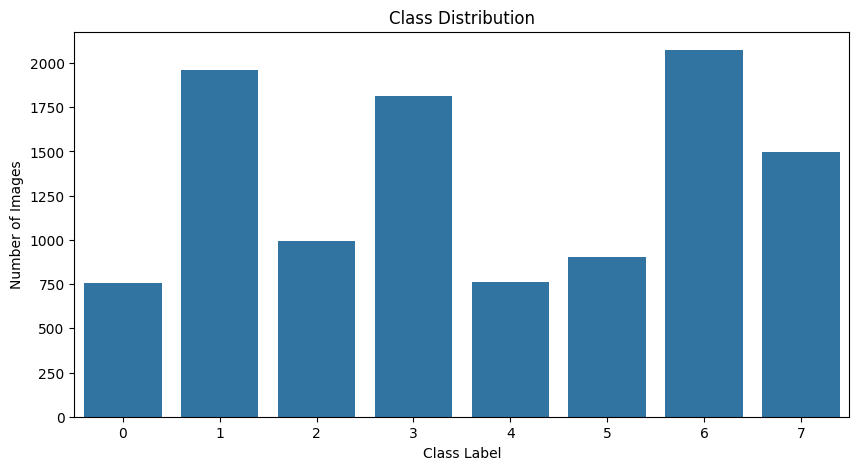

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.countplot(x=train_labels)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.show()


In [ ]:
# Find majority class and co
majority_class = class_counts.idxmax()
majority_count = class_counts.max()

In [ ]:
# Apply 90 rotation to oversampled images
modify_image = tf.keras.Sequential([
    tfkl.Lambda(lambda x: tf.image.rot90(x, k=2))
])

In [ ]:
class Rotate180(tfkl.Layer):
    def __init__(self, **kwargs):
        super(Rotate180, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.image.rot90(inputs, k=2)

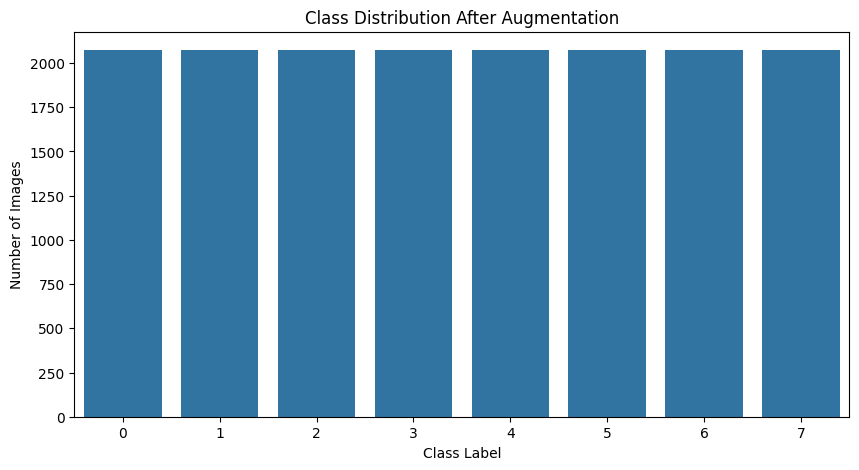

In [ ]:
# Balance dataset
minority_classes = class_counts[class_counts != majority_count].index
augmented_images = []
augmented_labels = []

for class_label in minority_classes:
    minority_indices = np.where(train_labels == class_label)[0]
    num_to_augment = majority_count - len(minority_indices)

    for i in range(num_to_augment):
        random_index = np.random.choice(minority_indices)
        image = train_images[random_index]

        augmented_image = modify_image(image)
        augmented_images.append(augmented_image.numpy())
        augmented_labels.append(class_label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine original and augmented data
train_images = np.concatenate((train_images, augmented_images))
train_labels = np.concatenate((train_labels, augmented_labels))

#Check the new class distribution
class_counts = pd.Series(train_labels).value_counts()
plt.figure(figsize=(10, 5))
sns.countplot(x=train_labels)
plt.title('Class Distribution After Augmentation')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.show()

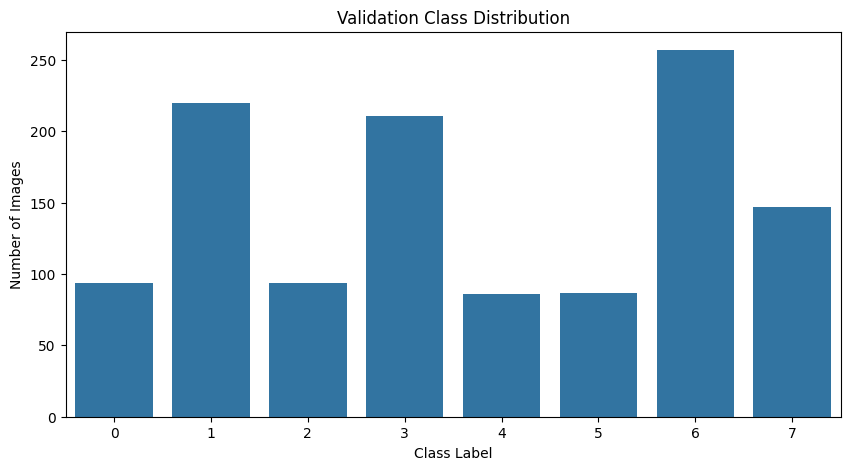

In [ ]:
# Plot val class distribution
class_counts = pd.Series(val_labels).value_counts()
plt.figure(figsize=(10, 5))
sns.countplot(x=val_labels)
plt.title('Validation Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
# Save dataset
np.savez_compressed('/gdrive/MyDrive/blood/data_preprocessed_balanced.npz',
                    train_images=train_images, train_labels=train_labels,
                    val_images=val_images, val_labels=val_labels)